In [1]:
import h5py
import numpy as np
import pandas as pd
import glob
import scipy.io
import matplotlib.pyplot as plt

def read_and_stack_h5_files(folder_path, file_pattern):
    # Find all .h5 files matching the pattern
    file_paths = sorted(glob.glob(f"{folder_path}/{file_pattern}"))
    df_list = []
    # Iterate over the file paths and read the data into DataFrames
    for file_path in file_paths:
        df_head = pd.read_hdf(file_path)
        df_head = df_head['DLC_resnet50_HeadJun17shuffle1_500000']
        df_list.append(df_head)

    # Concatenate all DataFrames in the list
    df_head = pd.concat(df_list, axis=0, ignore_index=True)

    return df_head

folder_path = './Fig8e'
file_pattern = 'real_2024-04-12-*.h5'
df_head = read_and_stack_h5_files(folder_path, file_pattern)

# Display the shape of the stacked data
print(f"Shape of stacked data: {df_head.shape}")

file_path_mat = './Fig8e/light_dynamics 2024-04-12 4paired stimuli.mat'
mat_data = scipy.io.loadmat(file_path_mat)
df_light_full = pd.DataFrame(mat_data['light_dynamics']).transpose().values
L = df_light_full.shape[0]
DF = df_head.head(L)
print(f"Shape of stacked data: {DF.shape}")

Shape of stacked data: (211201, 18)
Shape of stacked data: (40800, 18)


Facing angles (first 20): [18.23741383 17.03721971 15.963479   15.5094679  14.71059243 14.11287915
 13.72760698 13.07593388 12.51521554 12.31174249 11.74648259 11.05886255
 10.93513633 10.78064458 10.53997945 10.2471268   5.64547323  5.60263727
  4.98547168  4.75417284]


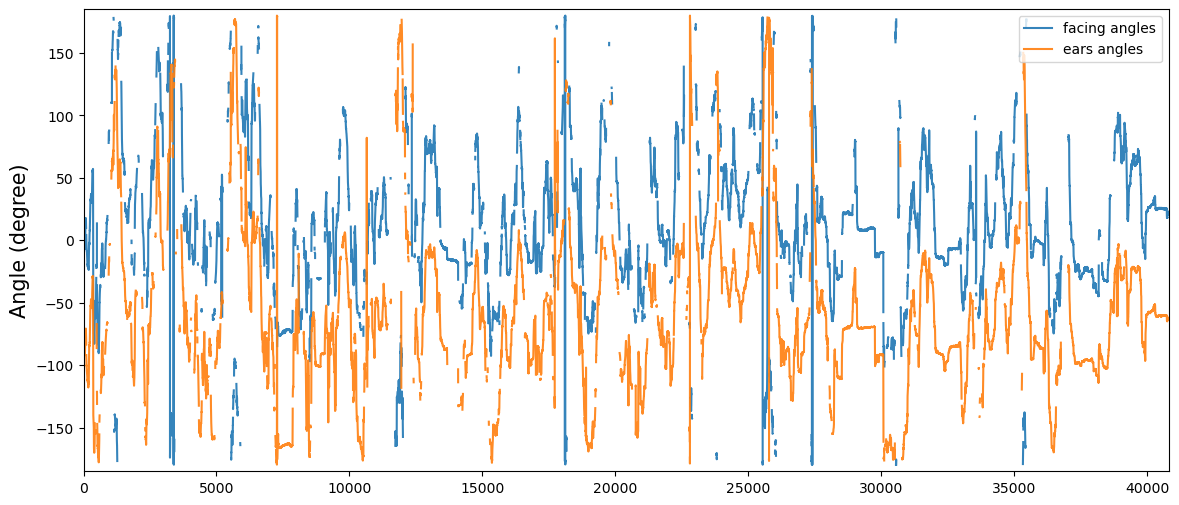

In [2]:
def compute_angles(front, back):
    """
    Compute the angles based on the coordinates of the front&back, left&right points,
    considering the likelihood values.
    
    Arguments:
    front -- numpy array of shape (#frames, 3) with columns (x, y, likelihood)
    back -- numpy array of shape (#frames, 3) with columns (x, y, likelihood)
    
    Returns:
    angles_degrees -- numpy array of shape (#frames,) with angles in degrees,
                      or np.nan for invalid angles
    """
    # Initialize an array for the angles+centers
    angles_degrees = np.full(front.shape[0], np.nan)
    vector_centers = np.full((front.shape[0],2), np.nan)
    
    # Filter data points with likelihood >= 0.95
    valid_indices = (front[:, 2] >= 0.95) & (back[:, 2] >= 0.95)
    
    # Compute center of vectors for valid points
    vector_centers_valid = back[valid_indices, :2]/2 + front[valid_indices, :2]/2
    vector_centers[valid_indices,:] = vector_centers_valid
    
    # Compute direction vectors for valid points
    direction_vectors = back[valid_indices, :2] - front[valid_indices, :2]
    
    # Compute angles using atan2
    angles_radians = np.arctan2(direction_vectors[:, 1], direction_vectors[:, 0])
    
    # Convert angles to degrees
    angles_degrees[valid_indices] = np.degrees(angles_radians)
    
    return angles_degrees, vector_centers

front = DF['Front'].values
back = DF['Back'].values

facing_angles, facing_centers = compute_angles(front, back)
print(f"Facing angles (first 20): {facing_angles[:20]}")

L_Ear = DF['L-Ear'].values
R_Ear = DF['R-Ear'].values
ears_angles, ears_centers = compute_angles(L_Ear, R_Ear)

plt.figure(figsize=(14, 6))
plt.plot(facing_angles, alpha=0.9, label='facing angles')
plt.plot(ears_angles, alpha=0.9, label='ears angles')
plt.xlim(0, L)
plt.ylabel('Angle (degree)', fontsize=15)
plt.ylim(-185, 185)
plt.legend()

Time points of the first pulse starts: [296, 5162, 9952, 14973, 19934, 25465, 30953, 36043]


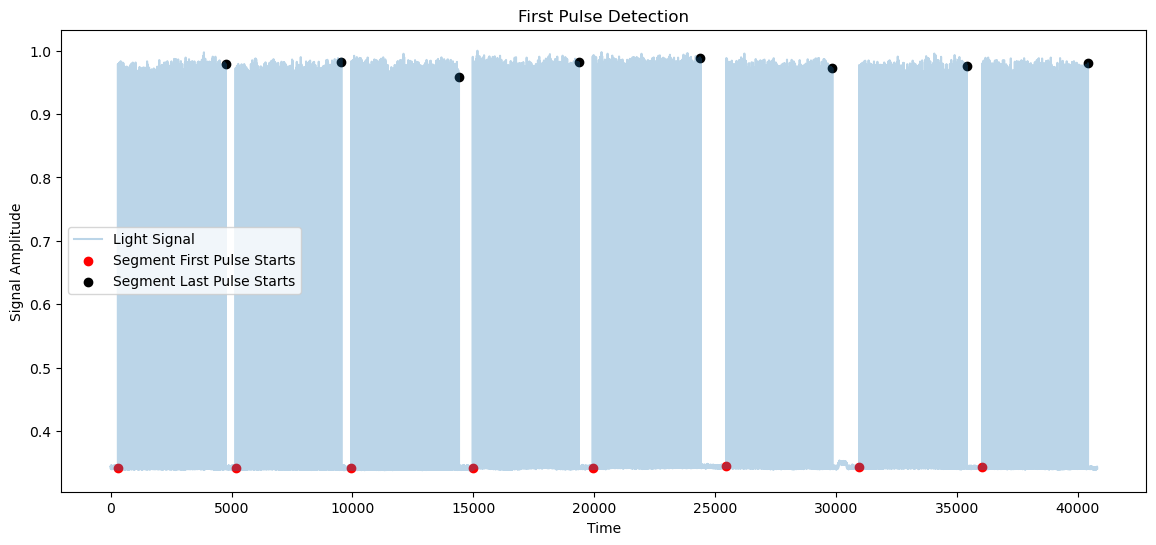

In [3]:
df_light = df_light_full/np.max(df_light_full)
diff = np.diff(np.squeeze(df_light)) ### must use "squeeze" otherwise "np.diff" will fail 

segment_threshold = 0.3
segments = np.where(np.abs(diff) > segment_threshold)[0] - 1  # +1 to correct the shift due to np.diff

### Identify the start of each segment
segment_starts = []
segment_ends = []
last_segment_end = 0
for seg in segments: ## loop through all pulses
    if seg > last_segment_end + 50:  # Assuming a gap of 50 points to consider it a new segment
        segment_starts.append(seg)
        if last_segment_end > 0:
            segment_ends.append(last_segment_end)
    last_segment_end = seg
segment_ends.append(last_segment_end)
    
print("Time points of the first pulse starts:", segment_starts)
plt.figure(figsize=(14, 6))
plt.plot(df_light, alpha=0.3, label='Light Signal') ### df_light
plt.scatter(segment_starts, df_light[segment_starts], color='red', label='Segment First Pulse Starts')
plt.scatter(segment_ends, df_light[segment_ends], color='black', label='Segment Last Pulse Starts')
plt.xlabel('Time')
# plt.xlim(0, 500)
plt.ylabel('Signal Amplitude')
plt.legend()
plt.title('First Pulse Detection')
plt.show()

Random Start: [296, 9952, 19934, 30953]
Random End: [4751, 14405, 24394, 35411]
Contin Start: [5162, 14973, 25465, 36043]
Contin End: [9540, 19349, 29848, 40423]
Random trials: 4456.5
Continuous trials: 4379.0


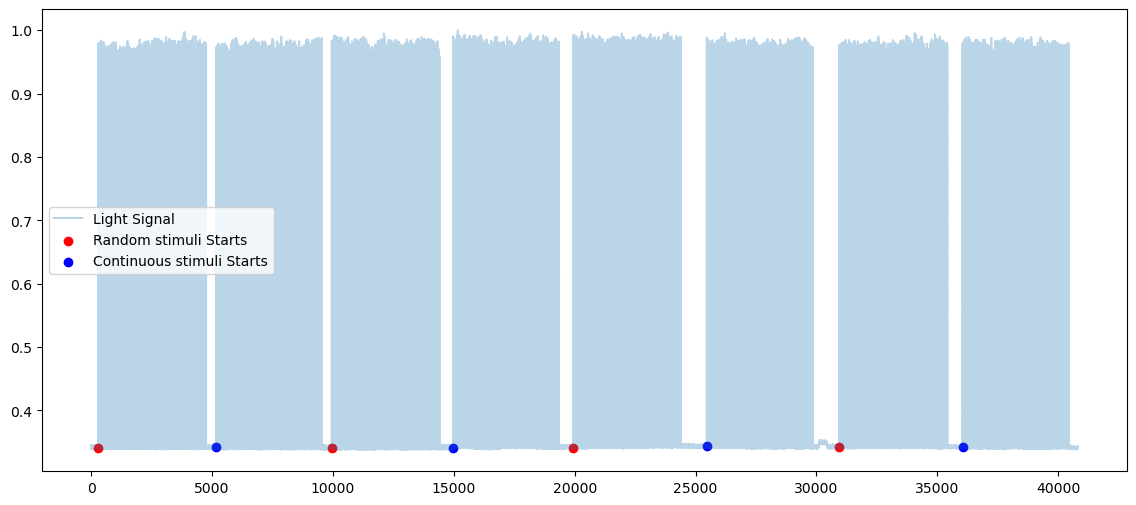

In [4]:
random_start = segment_starts[::2]
contin_start = segment_starts[1::2]

random_end = segment_ends[::2]
contin_end = segment_ends[1::2]
print("Random Start:", random_start)
print("Random End:", random_end)
print("Contin Start:", contin_start)
print("Contin End:", contin_end)

print("Random trials:", np.median(np.array(random_end)-np.array(random_start))) ### 32speakers*5rep=96stimuli
print("Continuous trials:", np.median(np.array(contin_end)-np.array(contin_start))) 

plt.figure(figsize=(14, 6))
plt.plot(df_light, alpha=0.3, label='Light Signal')
plt.scatter(random_start, df_light[random_start], color='red', label='Random stimuli Starts')
plt.scatter(contin_start, df_light[contin_start], color='blue', label='Continuous stimuli Starts')
plt.legend()

In [5]:
%matplotlib inline
L_random = 4460
L_contin = 4380

ears_angles_segments_equal = [ears_angles[start:start + L_random] for start in random_start]
temp = ears_angles_segments_equal[3]
ears_angles_segments_contin = [ears_angles[start:start + L_contin] for start in contin_start] 
ears_angles_segments_equal[3] = ears_angles_segments_contin[1]
ears_angles_segments_contin[1] = temp

N = len(random_start)+1  ### number of trials

step = 360

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sess= 1 cont len= 6.2 s
sess= 1 cont len= 5.2 s
sess= 1 cont len= 5.95 s
sess= 1 cont len= 5.1 s
sess= 1 cont len= 10.4 s
sess= 1 cont len= 5.3 s
sess= 2 cont len= 13.4 s
sess= 2 cont len= 11.3 s
sess= 2 cont len= 10.0 s
sess= 2 cont len= 13.8 s
sess= 3 cont len= 13.95 s
sess= 3 cont len= 17.05 s
sess= 3 cont len= 6.45 s
sess= 3 cont len= 12.55 s
sess= 3 cont len= 8.75 s
sess= 3 cont len= 6.9 s
sess= 3 cont len= 6.45 s
sess= 3 cont len= 8.65 s
sess= 4 cont len= 6.95 s
sess= 4 cont len= 13.35 s
sess= 4 cont len= 5.7 s
sess= 4 cont len= 11.4 s
sess= 4 cont len= 6.0 s
sess= 4 cont len= 13.7 s
sess= 4 cont len= 5.1 s
sess= 4 cont len= 7.25 s
sess= 4 cont len= 11.6 s
sess= 4 cont len= 7.0 s
sess= 4 cont len= 12.8 s


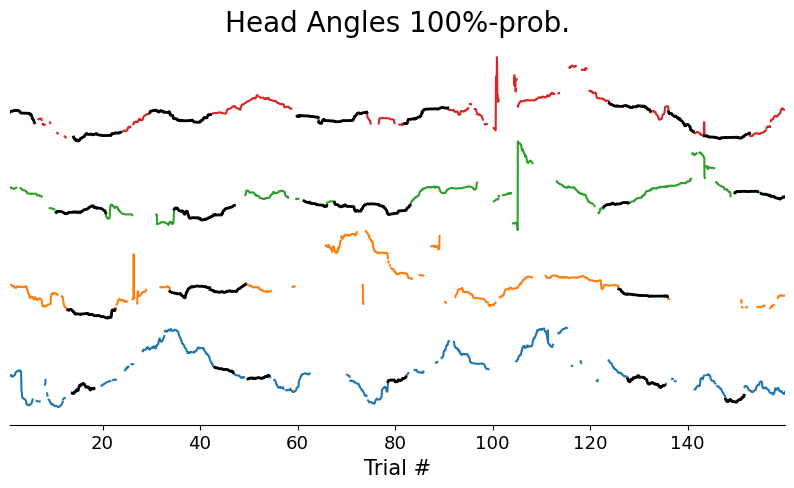

In [6]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
fps = 20 # frames per second
step = 360  # Offset step for visibility
highlight_color = 'black'  # Color for highlighting stable segments
threshold_fluctuation = 100  # Maximum frames with small fluctuations
threshold_amplitude = 5  # Percentage change threshold for small fluctuations
min_stable_length = 100  # Minimum length for a stable segment
dur_eql = []
for i, segment in enumerate(ears_angles_segments_equal):
    offset_segment = segment + i * step  # Offset each trace for visibility
    plt.plot(offset_segment, alpha=1)  # Plot the segment
    
    # Remove NaNs for processing
    segment_clean = segment
   
    # Calculate percentage change
    percentage_change = np.abs(np.diff(segment_clean) / segment_clean[:-1]) * 100
    stable_indices = percentage_change < threshold_amplitude

    # Identify stable regions
    start_idx, current_length = None, 0
    for j, is_stable in enumerate(stable_indices, 1):
        if is_stable:
            if start_idx is None:
                start_idx = j - 1  # Start of a new stable segment
            current_length += 1
        else:
            if current_length >= min_stable_length:
                plt.plot(
                    np.arange(start_idx, j),
                    offset_segment[start_idx:j],
                    color=highlight_color,
                    linewidth=2
                )
                dur_s = len(np.arange(start_idx, j))/fps
                print('sess=', str(i+1), 'cont len=', dur_s,'s')
                dur_eql.append(dur_s)
            start_idx, current_length = None, 0

    # Check last segment
    if current_length >= min_stable_length:
        plt.plot(
            np.arange(start_idx, len(segment_clean)),
            offset_segment[start_idx:],
            color=highlight_color,
            linewidth=2
        )

# Configure plot
plt.xlabel('Trial #', fontsize=15)

tick_positions = np.linspace(0, L_contin, 160, dtype=int)  # 160 repetitions (32 * 5)
tick_labels = np.arange(1, 161)
selected_ticks = np.arange(20, 160, 20)
selected_positions = tick_positions[selected_ticks - 1]  # Subtract 1 because labels start at 1, not 0
plt.xticks(selected_positions, selected_ticks, fontsize=13)

plt.yticks([])  # Turn off the y-axis
plt.xlim(0, L_contin)
ax.spines[['left', 'right', 'top']].set_visible(False)
plt.title('Head Angles 100%-prob.', fontsize=20)
plt.legend().set_visible(False)

# Save and display the plot
plt.savefig('Head Angles 4 Paired Sessions Equal-prob 5%-threshold.pdf', format='pdf')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sess= 1 cont len= 7.5 s
sess= 1 cont len= 29.15 s
sess= 1 cont len= 22.15 s
sess= 2 cont len= 12.0 s
sess= 2 cont len= 30.2 s
sess= 2 cont len= 30.35 s
sess= 2 cont len= 12.85 s
sess= 2 cont len= 13.65 s
sess= 2 cont len= 11.3 s
sess= 2 cont len= 5.25 s
sess= 3 cont len= 7.3 s
sess= 3 cont len= 5.4 s
sess= 3 cont len= 19.05 s
sess= 3 cont len= 6.8 s
sess= 3 cont len= 10.25 s
sess= 3 cont len= 7.9 s
sess= 3 cont len= 5.6 s
sess= 3 cont len= 6.45 s
sess= 3 cont len= 33.6 s
sess= 3 cont len= 33.8 s
sess= 4 cont len= 12.9 s
sess= 4 cont len= 55.1 s
sess= 4 cont len= 22.5 s
sess= 4 cont len= 16.6 s
sess= 4 cont len= 6.45 s


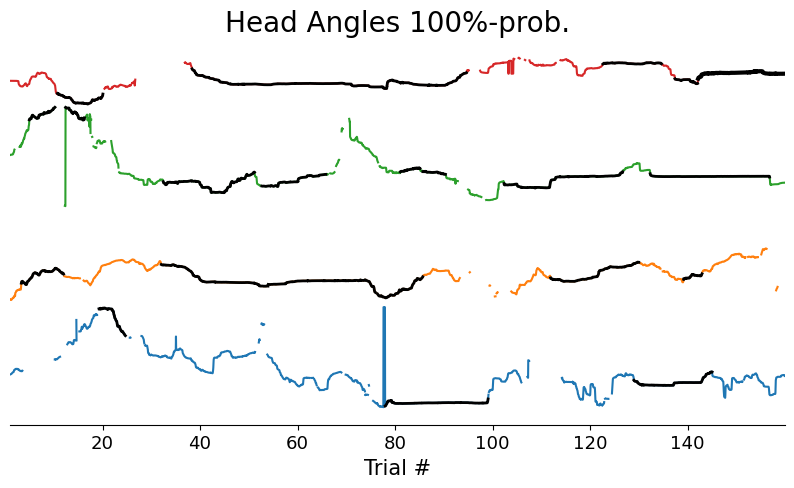

In [7]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)

step = 360  # Offset step for visibility
highlight_color = 'black'  # Color for highlighting stable segments
threshold_amplitude = 5  # Percentage change threshold for small fluctuations
min_stable_length = 100  # Minimum length for a stable segment
dur_con = []
for i, segment in enumerate(ears_angles_segments_contin):
    offset_segment = segment + i * step  # Offset each trace for visibility
    plt.plot(offset_segment, alpha=1)  # Plot the segment
    
    # Remove NaNs for processing
    segment_clean = segment
   
    # Calculate percentage change
    percentage_change = np.abs(np.diff(segment_clean) / segment_clean[:-1]) * 100
    stable_indices = percentage_change < threshold_amplitude

    # Identify stable regions
    start_idx, current_length = None, 0
    for j, is_stable in enumerate(stable_indices, 1):
        if is_stable:
            if start_idx is None:
                start_idx = j - 1  # Start of a new stable segment
            current_length += 1
        else:
            if current_length >= min_stable_length:
                plt.plot(
                    np.arange(start_idx, j),
                    offset_segment[start_idx:j],
                    color=highlight_color,
                    linewidth=2
                )
                dur_s = len(np.arange(start_idx, j))/fps
                print('sess=', str(i+1), 'cont len=', dur_s,'s')
                dur_con.append(dur_s)
            start_idx, current_length = None, 0

    # Check last segment
    if current_length >= min_stable_length:
        plt.plot(
            np.arange(start_idx, len(segment_clean)),
            offset_segment[start_idx:],
            color=highlight_color,
            linewidth=3
        )

# Configure plot
plt.xlabel('Trial #', fontsize=15)

tick_positions = np.linspace(0, L_contin, 160, dtype=int)  # 160 repetitions (32 * 5)
tick_labels = np.arange(1, 161)
selected_ticks = np.arange(20, 160, 20)
selected_positions = tick_positions[selected_ticks - 1]  # Subtract 1 because labels start at 1, not 0
plt.xticks(selected_positions, selected_ticks, fontsize=13)

plt.yticks([])  # Turn off the y-axis
plt.xlim(0, L_contin)
ax.spines[['left', 'right', 'top']].set_visible(False)  # Hide left, right, and top spines
plt.title('Head Angles 100%-prob.', fontsize=20)
plt.legend().set_visible(False)

# Save and display the plot
plt.savefig('Head Angles 4 Paired Sessions 100%-prob 5%-threshold.pdf', format='pdf')
plt.show()
